# 02 - Análisis Exploratorio de Datos (EDA)

Análisis exhaustivo de la serie temporal USD/CLP para entender:
- Tendencias y estacionalidad
- Volatilidad y outliers
- Estacionaridad
- Patrones temporales

## 1. Setup e Importación de Datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Configuración
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 6)
%matplotlib inline

# Configurar pandas para mejor visualización
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 2)

print(" Librerías cargadas")

 Librerías cargadas


In [2]:
# Cargar datos
df = pd.read_csv('../data/raw/dolar_bcch.csv', index_col='Fecha', parse_dates=True)
print(f" Datos cargados: {len(df):,} registros")
print(f" Rango: {df.index.min().date()} a {df.index.max().date()}")
df.head()

 Datos cargados: 10,956 registros
 Rango: 1995-10-09 a 2025-10-06


,Valor,statusCode
Fecha,,
1995-10-09,401.54,OK
1995-10-10,402.76,OK
1995-10-11,403.89,OK
1995-10-12,NaN,ND
1995-10-13,403.40,OK


## 2. Resumen Estadístico

In [3]:
# Información general
print("="*70)
print("INFORMACIÓN DEL DATASET")
print("="*70)
df.info()

print("\n" + "="*70)
print("ESTADÍSTICAS DESCRIPTIVAS")
print("="*70)
print(df['Valor'].describe())

print("\n" + "="*70)
print("VALORES FALTANTES")
print("="*70)
missing = df['Valor'].isna().sum()
total = len(df)
print(f"Total: {total:,}")
print(f"Valores válidos: {total - missing:,} ({(total-missing)/total*100:.2f}%)")
print(f"Valores faltantes: {missing:,} ({missing/total*100:.2f}%)")

INFORMACIÓN DEL DATASET
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10956 entries, 1995-10-09 to 2025-10-06
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Valor       7474 non-null   float64
 1   statusCode  10956 non-null  object 
dtypes: float64(1), object(1)
memory usage: 256.8+ KB

ESTADÍSTICAS DESCRIPTIVAS
count    7474.00
mean      618.71
std       146.56
min       401.54
25%       506.76
50%       590.10
75%       699.96
max      1042.97
Name: Valor, dtype: float64

VALORES FALTANTES
Total: 10,956
Valores válidos: 7,474 (68.22%)
Valores faltantes: 3,482 (31.78%)


## 3. Visualización de Serie Temporal

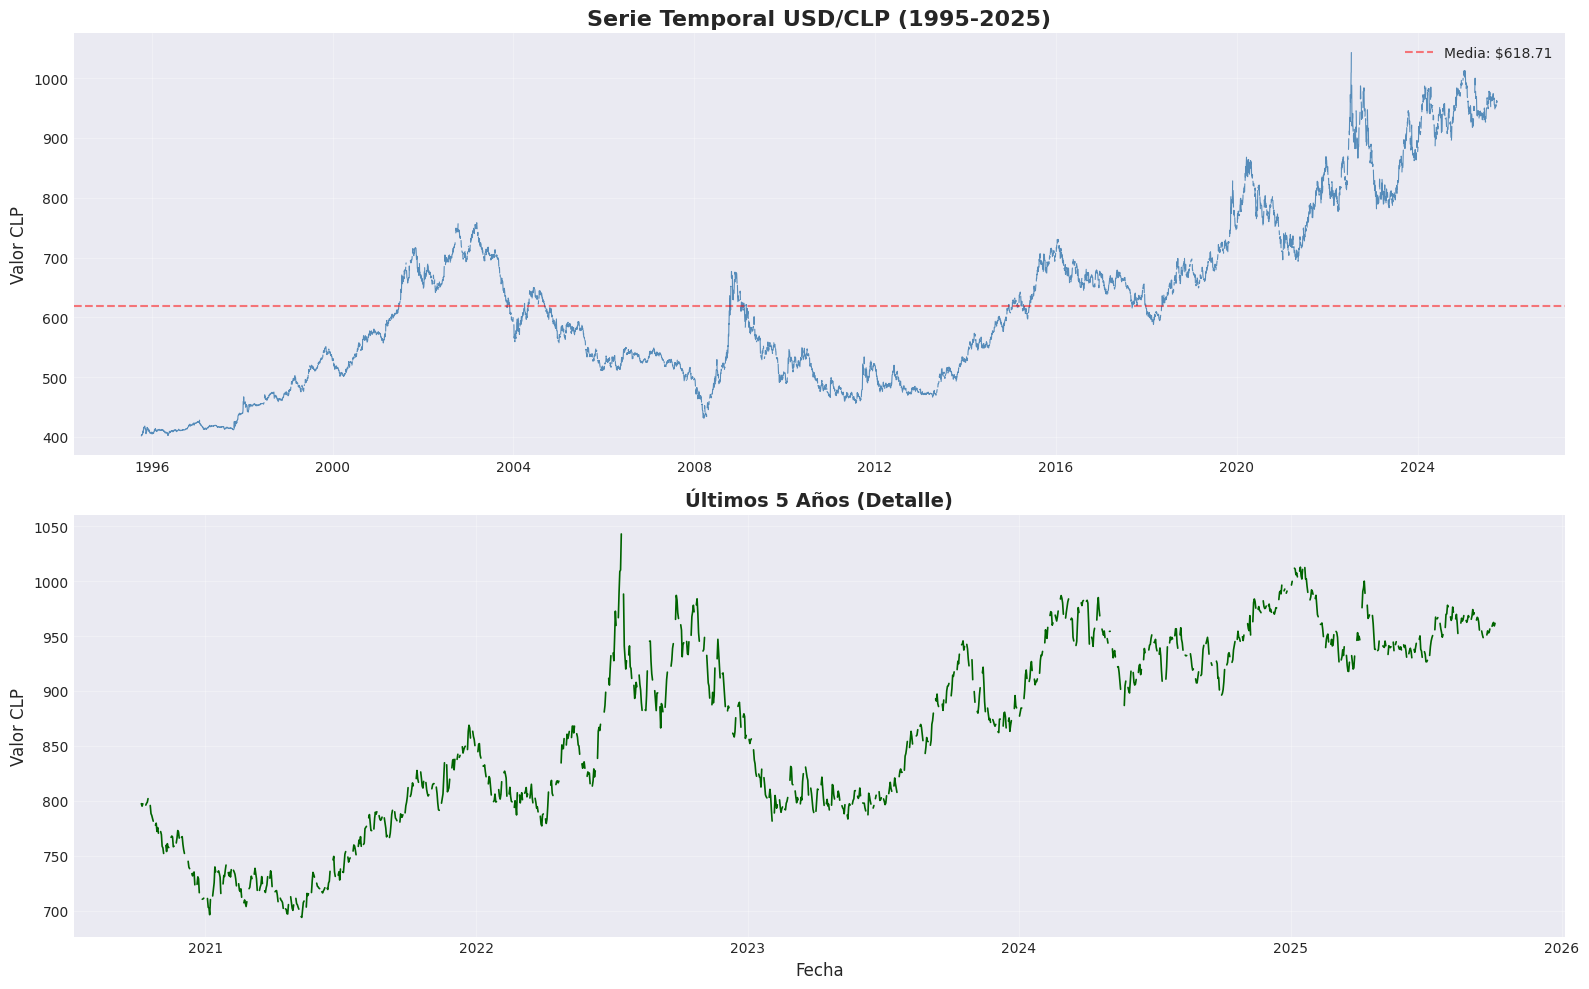

Valor mínimo histórico: $401.54 CLP (1995-10-09)
Valor máximo histórico: $1042.97 CLP (2022-07-15)
Valor promedio: $618.71 CLP
Desviación estándar: $146.56 CLP


In [4]:
# Serie temporal completa
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Gráfico principal
axes[0].plot(df.index, df['Valor'], linewidth=0.8, alpha=0.9, color='steelblue')
axes[0].set_title('Serie Temporal USD/CLP (1995-2025)', fontsize=16, fontweight='bold')
axes[0].set_ylabel('Valor CLP', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=df['Valor'].mean(), color='r', linestyle='--', alpha=0.5, label=f'Media: ${df["Valor"].mean():.2f}')
axes[0].legend()

# Últimos 5 años con más detalle
df_recent = df.loc[df.index >= (df.index.max() - pd.Timedelta(days=365*5))]
axes[1].plot(df_recent.index, df_recent['Valor'], linewidth=1.2, color='darkgreen')
axes[1].set_title('Últimos 5 Años (Detalle)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Fecha', fontsize=12)
axes[1].set_ylabel('Valor CLP', fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Valor mínimo histórico: ${df['Valor'].min():.2f} CLP ({df['Valor'].idxmin().date()})")
print(f"Valor máximo histórico: ${df['Valor'].max():.2f} CLP ({df['Valor'].idxmax().date()})")
print(f"Valor promedio: ${df['Valor'].mean():.2f} CLP")
print(f"Desviación estándar: ${df['Valor'].std():.2f} CLP")

## 4. Distribución de Valores

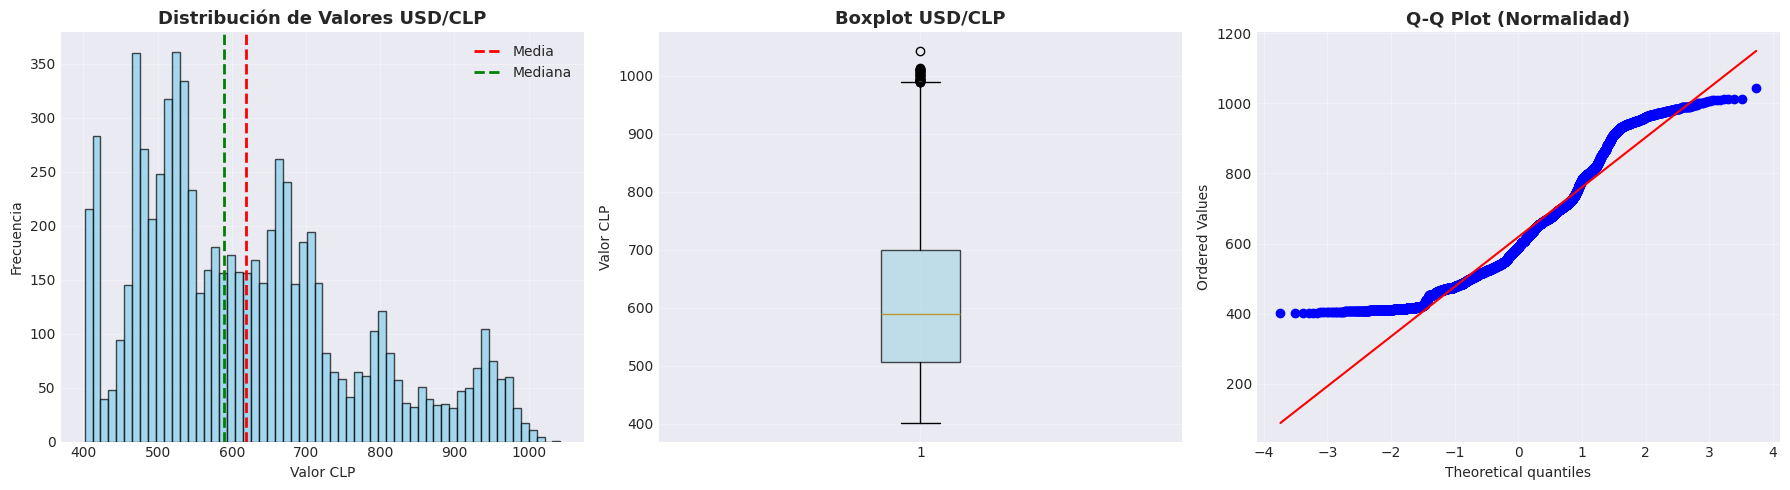


Test de Shapiro-Wilk: p-value = 0.000000
 Los datos NO siguen una distribución normal (p < 0.05)


In [5]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histograma
axes[0].hist(df['Valor'].dropna(), bins=60, edgecolor='black', alpha=0.7, color='skyblue')
axes[0].axvline(df['Valor'].mean(), color='red', linestyle='--', linewidth=2, label='Media')
axes[0].axvline(df['Valor'].median(), color='green', linestyle='--', linewidth=2, label='Mediana')
axes[0].set_title('Distribución de Valores USD/CLP', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Valor CLP')
axes[0].set_ylabel('Frecuencia')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Boxplot
axes[1].boxplot(df['Valor'].dropna(), vert=True, patch_artist=True,
                boxprops=dict(facecolor='lightblue', alpha=0.7))
axes[1].set_title('Boxplot USD/CLP', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Valor CLP')
axes[1].grid(True, alpha=0.3)

# Q-Q Plot (aproximado con scatter)
from scipy import stats
stats.probplot(df['Valor'].dropna(), dist="norm", plot=axes[2])
axes[2].set_title('Q-Q Plot (Normalidad)', fontsize=13, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Test de normalidad
from scipy.stats import shapiro, normaltest
stat_shapiro, p_shapiro = shapiro(df['Valor'].dropna().sample(5000))  # Muestra para Shapiro
print(f"\nTest de Shapiro-Wilk: p-value = {p_shapiro:.6f}")
if p_shapiro < 0.05:
    print(" Los datos NO siguen una distribución normal (p < 0.05)")
else:
    print(" Los datos siguen una distribución normal (p >= 0.05)")

## 5. Análisis de Tendencia y Estacionalidad

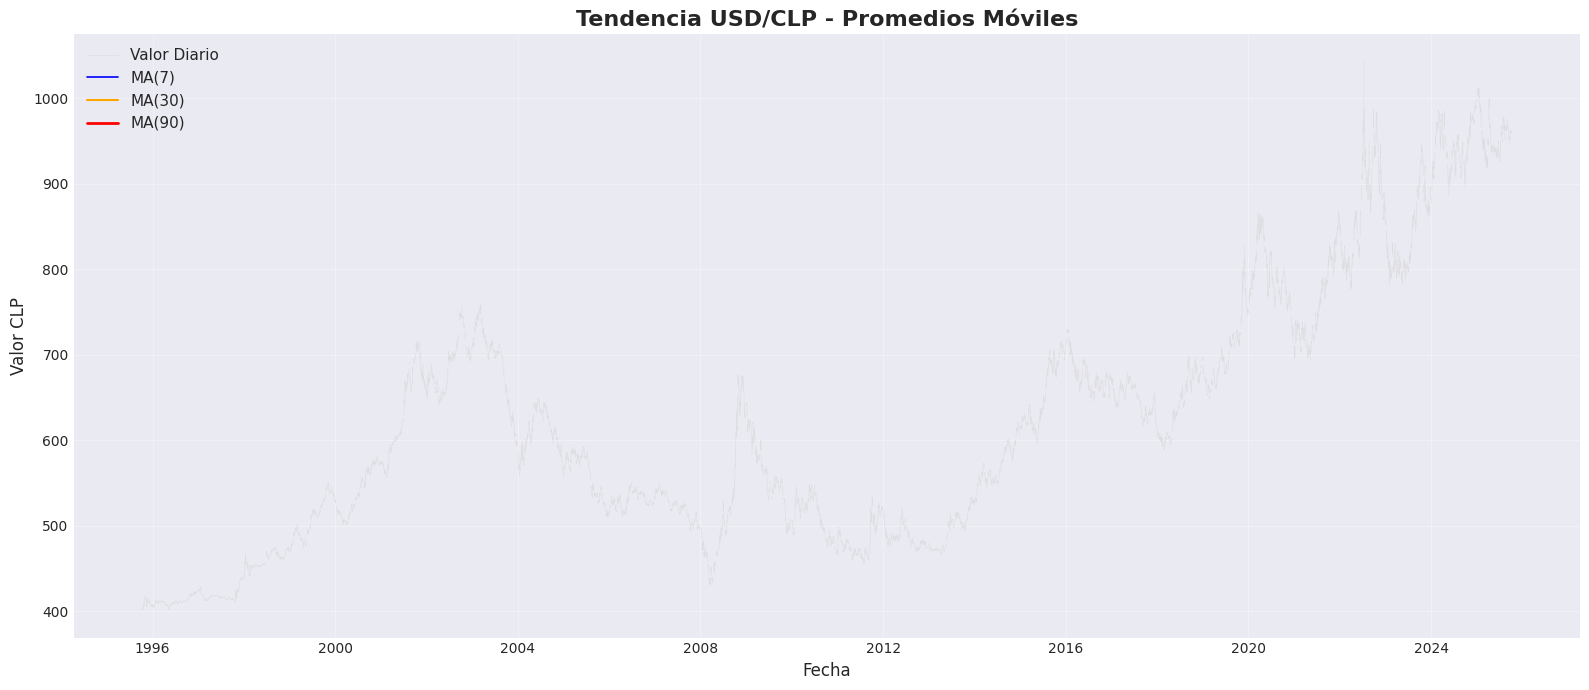

In [6]:
# Promedios móviles
df['MA_7'] = df['Valor'].rolling(window=7).mean()
df['MA_30'] = df['Valor'].rolling(window=30).mean()
df['MA_90'] = df['Valor'].rolling(window=90).mean()

plt.figure(figsize=(16, 7))
plt.plot(df.index, df['Valor'], linewidth=0.5, alpha=0.5, label='Valor Diario', color='lightgray')
plt.plot(df.index, df['MA_7'], linewidth=1.2, label='MA(7)', color='blue')
plt.plot(df.index, df['MA_30'], linewidth=1.5, label='MA(30)', color='orange')
plt.plot(df.index, df['MA_90'], linewidth=2, label='MA(90)', color='red')
plt.title('Tendencia USD/CLP - Promedios Móviles', fontsize=16, fontweight='bold')
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Valor CLP', fontsize=12)
plt.legend(loc='best', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

/tmp/ipykernel_13743/1594950418.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[0].boxplot(yearly_data, labels=sorted(df['Year'].unique()), patch_artist=True)


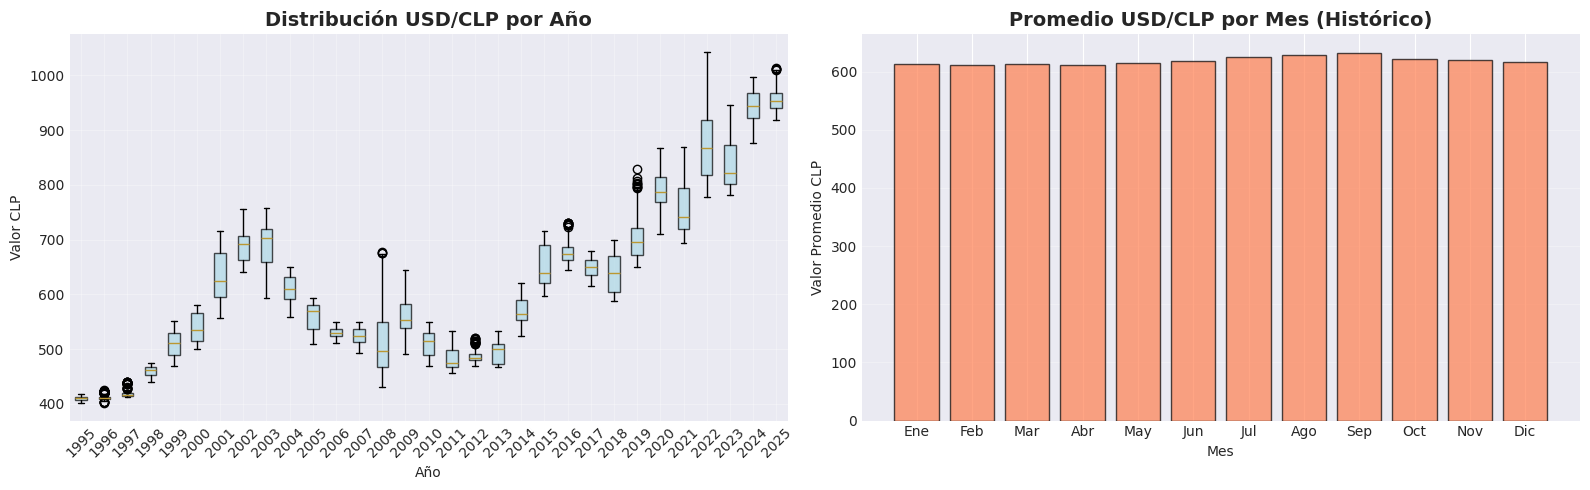

In [7]:
# Análisis por año
df['Year'] = df.index.year
df['Month'] = df.index.month
df['DayOfWeek'] = df.index.dayofweek

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Boxplot por año
yearly_data = [df[df['Year'] == year]['Valor'].dropna() for year in sorted(df['Year'].unique())]
bp = axes[0].boxplot(yearly_data, labels=sorted(df['Year'].unique()), patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
    patch.set_alpha(0.7)
axes[0].set_title('Distribución USD/CLP por Año', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Año')
axes[0].set_ylabel('Valor CLP')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3)

# Promedio por mes
monthly_avg = df.groupby('Month')['Valor'].mean()
axes[1].bar(monthly_avg.index, monthly_avg.values, color='coral', alpha=0.7, edgecolor='black')
axes[1].set_title('Promedio USD/CLP por Mes (Histórico)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Mes')
axes[1].set_ylabel('Valor Promedio CLP')
axes[1].set_xticks(range(1, 13))
axes[1].set_xticklabels(['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'])
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 6. Análisis de Volatilidad

/tmp/ipykernel_13743/1623504382.py:2: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Returns'] = df['Valor'].pct_change() * 100  # Porcentaje


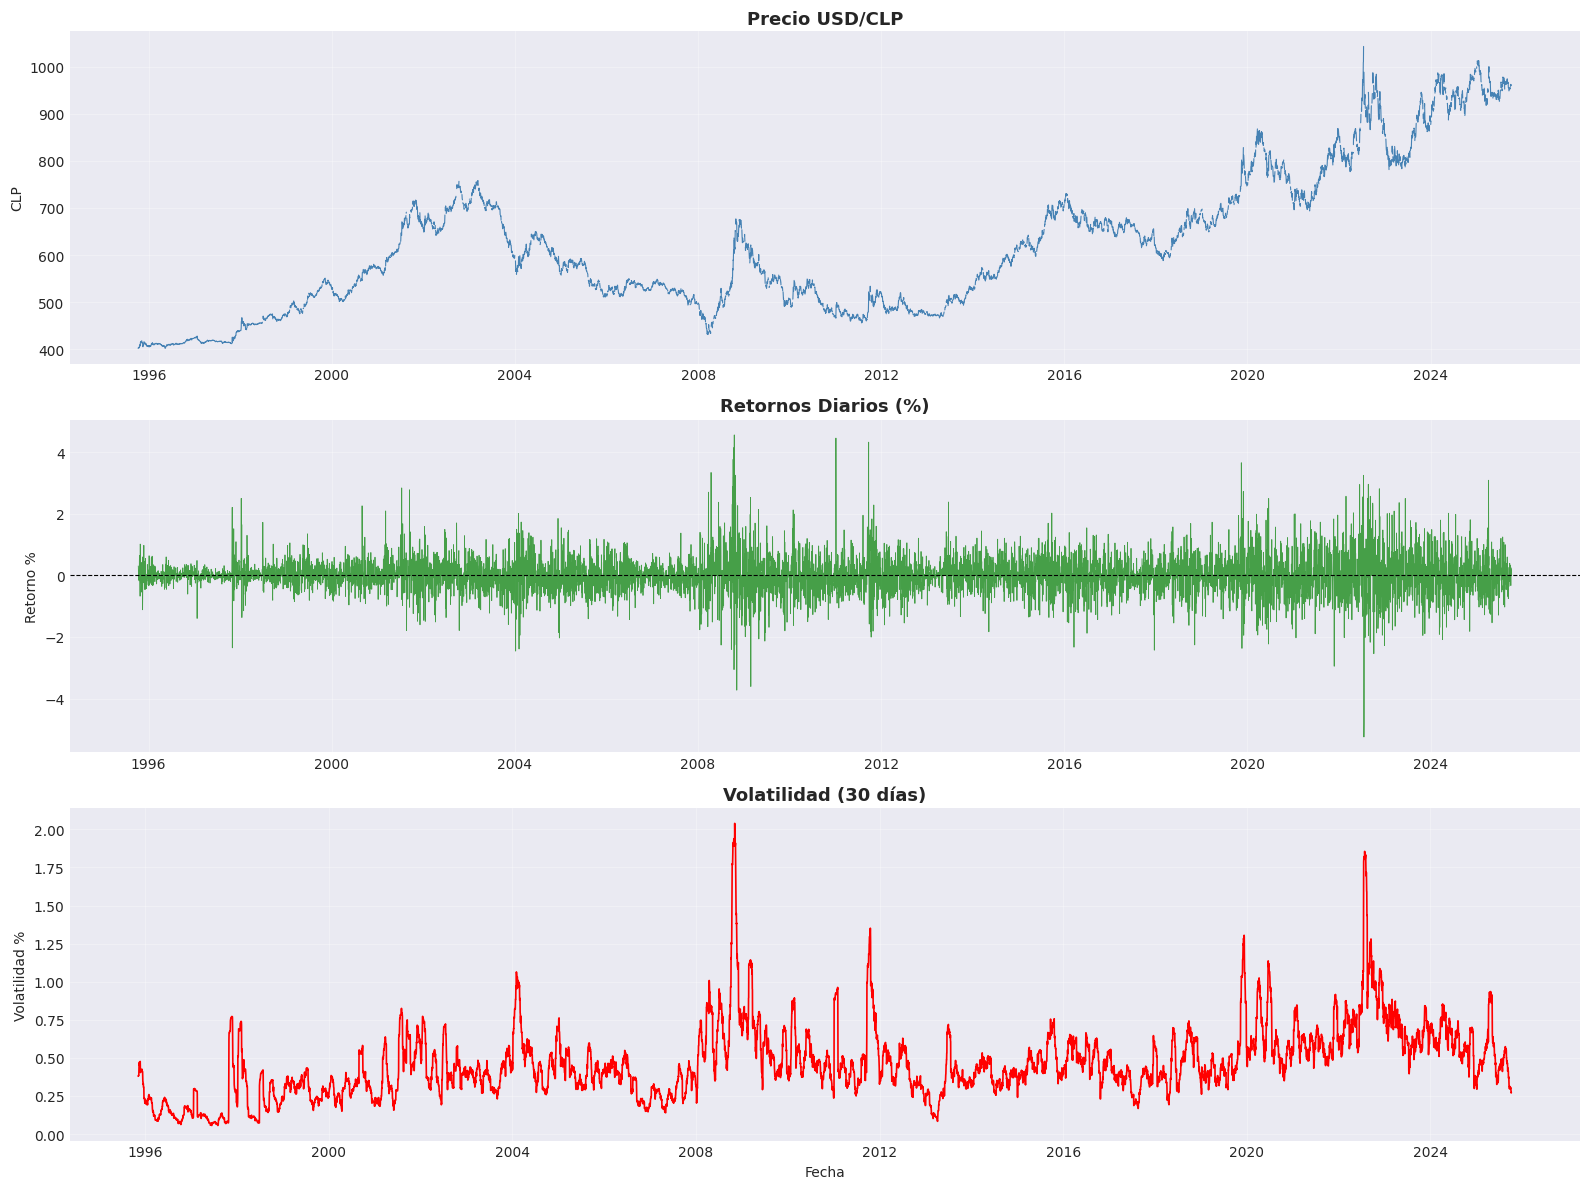


Retorno diario promedio: 0.0094%
Volatilidad promedio (30d): 0.4657%
Retorno máximo: 4.56% (2008-10-16)
Retorno mínimo: -5.25% (2022-07-18)


In [8]:
# Retornos diarios
df['Returns'] = df['Valor'].pct_change() * 100  # Porcentaje
df['Returns_Abs'] = df['Returns'].abs()

# Volatilidad móvil
df['Volatility_30'] = df['Returns'].rolling(window=30).std()

fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# Precio
axes[0].plot(df.index, df['Valor'], linewidth=0.8, color='steelblue')
axes[0].set_title('Precio USD/CLP', fontsize=13, fontweight='bold')
axes[0].set_ylabel('CLP')
axes[0].grid(True, alpha=0.3)

# Retornos diarios
axes[1].plot(df.index, df['Returns'], linewidth=0.6, color='green', alpha=0.7)
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=0.8)
axes[1].set_title('Retornos Diarios (%)', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Retorno %')
axes[1].grid(True, alpha=0.3)

# Volatilidad
axes[2].plot(df.index, df['Volatility_30'], linewidth=1.2, color='red')
axes[2].set_title('Volatilidad (30 días)', fontsize=13, fontweight='bold')
axes[2].set_xlabel('Fecha')
axes[2].set_ylabel('Volatilidad %')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nRetorno diario promedio: {df['Returns'].mean():.4f}%")
print(f"Volatilidad promedio (30d): {df['Volatility_30'].mean():.4f}%")
print(f"Retorno máximo: {df['Returns'].max():.2f}% ({df['Returns'].idxmax().date()})")
print(f"Retorno mínimo: {df['Returns'].min():.2f}% ({df['Returns'].idxmin().date()})")

## 7. Test de Estacionaridad (ADF)

In [9]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(series, name='Serie'):
    """Realiza el test Augmented Dickey-Fuller."""
    result = adfuller(series.dropna(), autolag='AIC')
    
    print(f"\n{'='*70}")
    print(f"TEST DE ESTACIONARIDAD (ADF) - {name}")
    print(f"{'='*70}")
    print(f"ADF Statistic: {result[0]:.6f}")
    print(f"p-value: {result[1]:.6f}")
    print(f"Lags utilizados: {result[2]}")
    print(f"Observaciones: {result[3]}")
    print("\nValores críticos:")
    for key, value in result[4].items():
        print(f"  {key}: {value:.4f}")
    
    if result[1] < 0.05:
        print(f"\n La serie ES ESTACIONARIA (p-value < 0.05)")
    else:
        print(f"\n La serie NO ES ESTACIONARIA (p-value >= 0.05)")
        print("   Considerar diferenciación o transformación logarítmica")
    
    return result

# Test en serie original
test_stationarity(df['Valor'], 'Valor USD/CLP')

# Test en retornos
test_stationarity(df['Returns'], 'Retornos Diarios')


TEST DE ESTACIONARIDAD (ADF) - Valor USD/CLP
ADF Statistic: -0.723190
p-value: 0.840651
Lags utilizados: 26
Observaciones: 7447

Valores críticos:
  1%: -3.4312
  5%: -2.8619
  10%: -2.5670

 La serie NO ES ESTACIONARIA (p-value >= 0.05)
   Considerar diferenciación o transformación logarítmica

TEST DE ESTACIONARIDAD (ADF) - Retornos Diarios
ADF Statistic: -18.017473
p-value: 0.000000
Lags utilizados: 34
Observaciones: 10920

Valores críticos:
  1%: -3.4309
  5%: -2.8618
  10%: -2.5669

 La serie ES ESTACIONARIA (p-value < 0.05)


(np.float64(-18.017472683924396),
 np.float64(2.7020557805293564e-30),
 34,
 10920,
 {'1%': np.float64(-3.4309489778246895),
  '5%': np.float64(-2.8618047150242414),
  '10%': np.float64(-2.566910902677146)},
 np.float64(16591.089066812878))

## 8. Autocorrelación

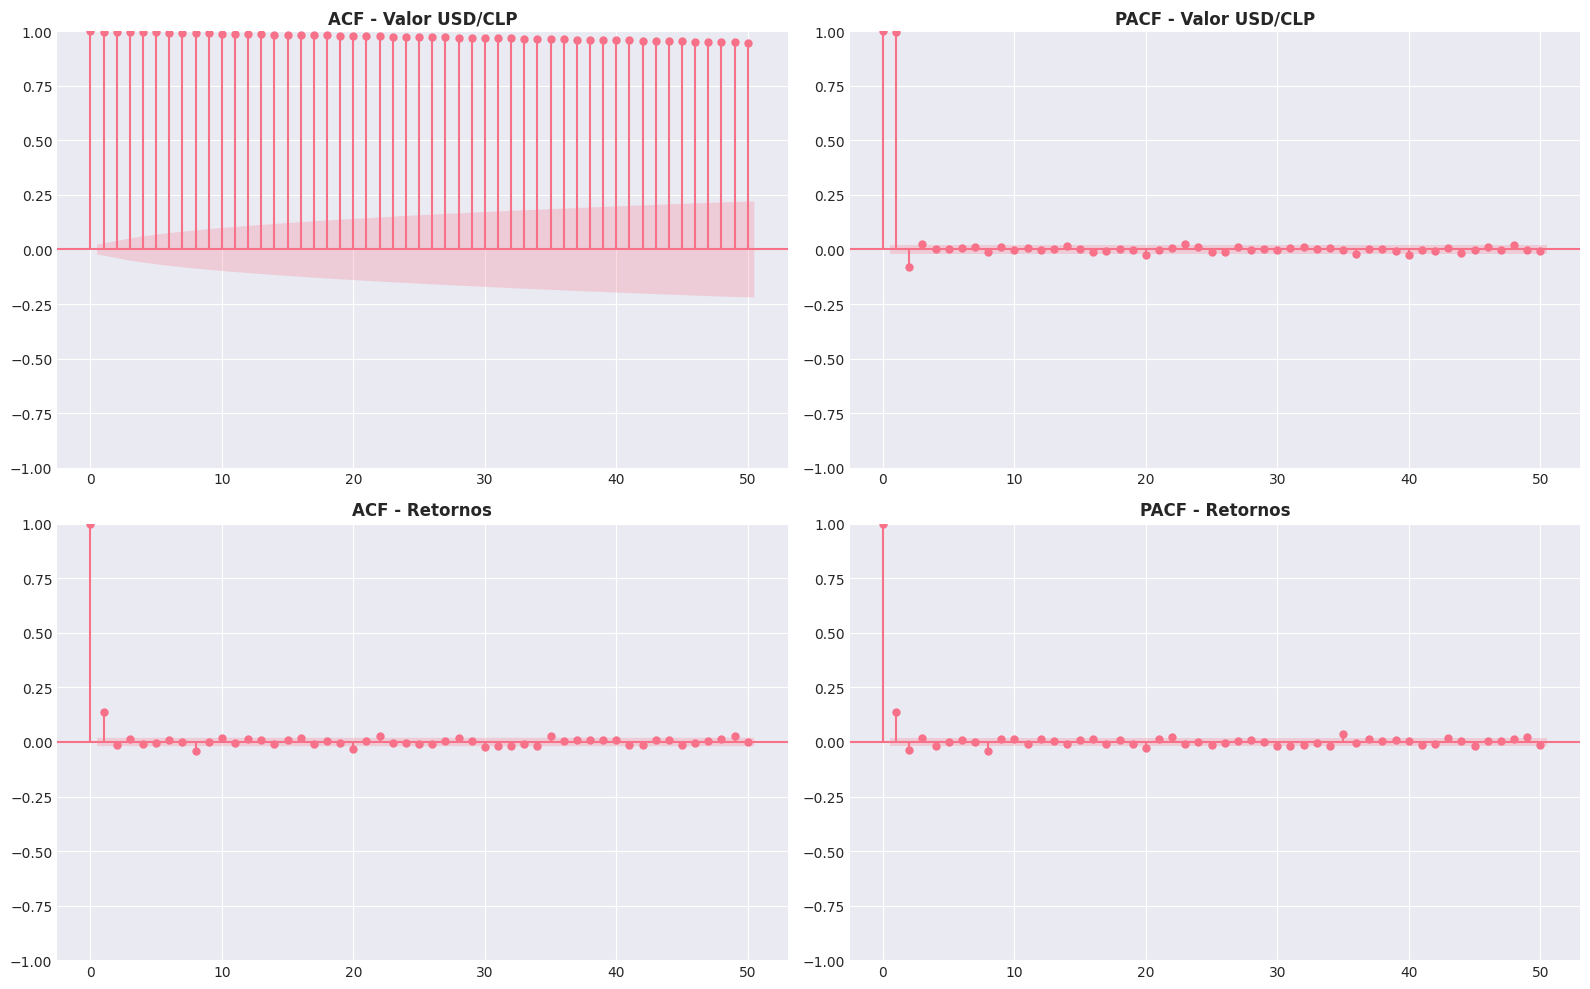

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# ACF y PACF del valor
plot_acf(df['Valor'].dropna(), lags=50, ax=axes[0, 0])
axes[0, 0].set_title('ACF - Valor USD/CLP', fontsize=12, fontweight='bold')

plot_pacf(df['Valor'].dropna(), lags=50, ax=axes[0, 1])
axes[0, 1].set_title('PACF - Valor USD/CLP', fontsize=12, fontweight='bold')

# ACF y PACF de retornos
plot_acf(df['Returns'].dropna(), lags=50, ax=axes[1, 0])
axes[1, 0].set_title('ACF - Retornos', fontsize=12, fontweight='bold')

plot_pacf(df['Returns'].dropna(), lags=50, ax=axes[1, 1])
axes[1, 1].set_title('PACF - Retornos', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## 9. Detección de Outliers


DETECCIÓN DE OUTLIERS (Método IQR)
Q1: $506.76
Q3: $699.96
IQR: $193.20
Límite inferior: $216.96
Límite superior: $989.75

Outliers detectados: 33 (0.30%)

Primeros 10 outliers:
              Valor
Fecha              
2022-07-12   989.95
2022-07-13  1008.81
2022-07-14  1010.16
2022-07-15  1042.97
2024-12-17   989.93
2024-12-18   990.87
2024-12-20   996.35
2024-12-23   991.18
2024-12-24   992.78
2024-12-27   990.95


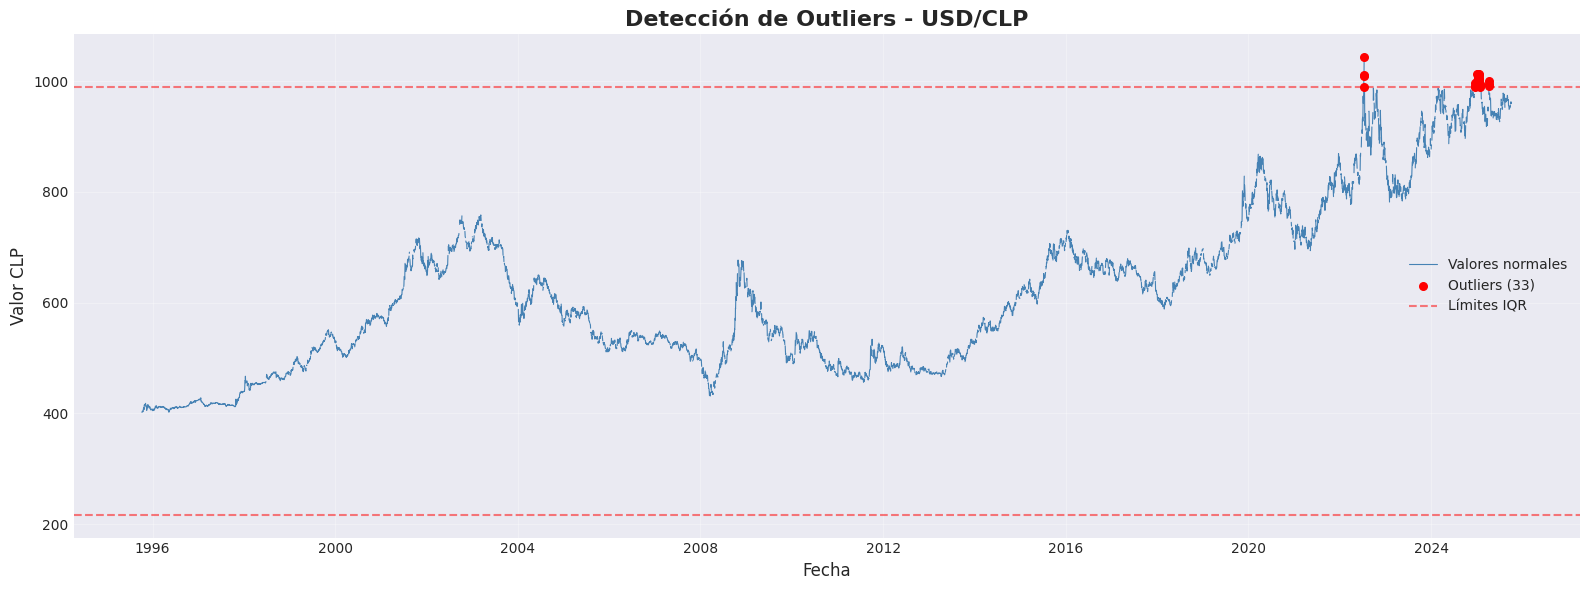

In [11]:
# Outliers usando IQR
Q1 = df['Valor'].quantile(0.25)
Q3 = df['Valor'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['Valor'] < lower_bound) | (df['Valor'] > upper_bound)]

print(f"\n{'='*70}")
print("DETECCIÓN DE OUTLIERS (Método IQR)")
print(f"{'='*70}")
print(f"Q1: ${Q1:.2f}")
print(f"Q3: ${Q3:.2f}")
print(f"IQR: ${IQR:.2f}")
print(f"Límite inferior: ${lower_bound:.2f}")
print(f"Límite superior: ${upper_bound:.2f}")
print(f"\nOutliers detectados: {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")

if len(outliers) > 0:
    print("\nPrimeros 10 outliers:")
    print(outliers[['Valor']].head(10))

# Visualización
plt.figure(figsize=(16, 6))
plt.plot(df.index, df['Valor'], linewidth=0.8, color='steelblue', label='Valores normales')
plt.scatter(outliers.index, outliers['Valor'], color='red', s=30, label=f'Outliers ({len(outliers)})', zorder=5)
plt.axhline(y=upper_bound, color='red', linestyle='--', alpha=0.5, label='Límites IQR')
plt.axhline(y=lower_bound, color='red', linestyle='--', alpha=0.5)
plt.title('Detección de Outliers - USD/CLP', fontsize=16, fontweight='bold')
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Valor CLP', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 10. Resumen y Conclusiones

In [12]:
print("\n" + "="*70)
print("RESUMEN DEL ANÁLISIS EXPLORATORIO")
print("="*70)

print("\n ESTADÍSTICAS GENERALES:")
print(f"  • Total de observaciones: {len(df):,}")
print(f"  • Rango de fechas: {df.index.min().date()} a {df.index.max().date()}")
print(f"  • Valores válidos: {df['Valor'].notna().sum():,} ({df['Valor'].notna().sum()/len(df)*100:.2f}%)")
print(f"  • Valores faltantes: {df['Valor'].isna().sum():,} ({df['Valor'].isna().sum()/len(df)*100:.2f}%)")

print("\n VALORES USD/CLP:")
print(f"  • Mínimo: ${df['Valor'].min():.2f}")
print(f"  • Máximo: ${df['Valor'].max():.2f}")
print(f"  • Promedio: ${df['Valor'].mean():.2f}")
print(f"  • Mediana: ${df['Valor'].median():.2f}")
print(f"  • Desviación estándar: ${df['Valor'].std():.2f}")

print("\n VOLATILIDAD:")
print(f"  • Retorno diario promedio: {df['Returns'].mean():.4f}%")
print(f"  • Volatilidad promedio (30d): {df['Volatility_30'].mean():.4f}%")
print(f"  • Retorno máximo: {df['Returns'].max():.2f}%")
print(f"  • Retorno mínimo: {df['Returns'].min():.2f}%")

print("\n OUTLIERS:")
print(f"  • Outliers detectados: {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")

print("\n PRÓXIMOS PASOS:")
print("  1. Feature Engineering (crear variables lag, MA, etc.)")
print("  2. Manejo de valores faltantes (forward fill)")
print("  3. Creación de features temporales (día, mes, trimestre)")
print("  4. Preparación de datos para modelado")
print("\nSiguiente notebook: 03_feature_engineering.ipynb")


RESUMEN DEL ANÁLISIS EXPLORATORIO

 ESTADÍSTICAS GENERALES:
  • Total de observaciones: 10,956
  • Rango de fechas: 1995-10-09 a 2025-10-06
  • Valores válidos: 7,474 (68.22%)
  • Valores faltantes: 3,482 (31.78%)

 VALORES USD/CLP:
  • Mínimo: $401.54
  • Máximo: $1042.97
  • Promedio: $618.71
  • Mediana: $590.10
  • Desviación estándar: $146.56

 VOLATILIDAD:
  • Retorno diario promedio: 0.0094%
  • Volatilidad promedio (30d): 0.4657%
  • Retorno máximo: 4.56%
  • Retorno mínimo: -5.25%

 OUTLIERS:
  • Outliers detectados: 33 (0.30%)

 PRÓXIMOS PASOS:
  1. Feature Engineering (crear variables lag, MA, etc.)
  2. Manejo de valores faltantes (forward fill)
  3. Creación de features temporales (día, mes, trimestre)
  4. Preparación de datos para modelado

Siguiente notebook: 03_feature_engineering.ipynb
